# Denoise & Project Notebook

## Goal: apply denoising model to images, and project z-stack into single image
Input: raw data/trained denoising model

Output: denoised and projected images

## Basic Setup
1. Import Tensorflow and check to make sure we are using GPU
2. Import N2V and dependencies

In [1]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from PIL import Image
import random
import tifffile #as tf # this is a huge problem, i need to stop importing this as tf

In [3]:
from pycromanager import Dataset


Note: here we are also brining in our "utils/helper functions":
- import pycro_scope_control.pycro_funcs as pf
- import pycro_scope_control.analysis_funcs as af

In [4]:
import sys
import os
repos_path = os.path.join('C:\\','Users','LevineLab','Documents','Repos')
if repos_path not in sys.path:
    sys.path.append(repos_path)


from pycromanager import Acquisition, multi_d_acquisition_events, Dataset, Core, Studio# , Bridge
import numpy as np
import matplotlib.pyplot as plt
import time

import threading
import datetime

import pycro_scope_control.pycro_funcs as pf
import pycro_scope_control.analysis_funcs as af

from skimage import morphology, exposure, filters, measure
from scipy import signal, ndimage
import copy
from scipy import stats


['C:\\Users\\LevineLab\\Documents\\tensorflow_notebooks', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\python39.zip', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\DLLs', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf', '', 'C:\\Users\\LevineLab\\AppData\\Roaming\\Python\\Python39\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\lib\\site-packages', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\lib\\site-packages\\win32', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\lib\\site-packages\\win32\\lib', 'C:\\ProgramData\\Anaconda3\\envs\\pumps_pycro_tf\\lib\\site-packages\\Pythonwin', 'C:\\Users\\LevineLab\\Documents\\Repos']


## Reading in Data
Input: 
- Raw data from a given experiment
- Trained model

Select:
1. experiment date
2. experiment folder
3. filename base
4. denoising model

In [5]:
os.getcwd()

'C:\\Users\\LevineLab\\Documents\\tensorflow_notebooks'

In [6]:
path = r"C:\Users\LevineLab\Documents\python notebooks\Wspa_EXPERIMENT_6_4_23"
exp_name = "StripA_cent1G_5h_jub39R_5h_6h_devA1_1"

In [7]:
dataset = Dataset(os.path.join(path,exp_name))

Dataset opened                


Getting the trained model:

In [8]:
model_name = 'n2v_wspa_5_4_23_red_train_v11'
basedir = r"C:\Users\LevineLab\Documents\python notebooks\Wspa_EXPERIMENT_6_4_23\models"

model_import = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


Looking at specifically worm 5 for demonstration purposes:

In [12]:
wstack = af.get_wstack(dataset,pos = 5)
wstack.shape

(3, 9, 2048, 2048)

## Denoising the images
Here, we display the entire z-stack and apply the denoising model.

Displaying the z-stack:

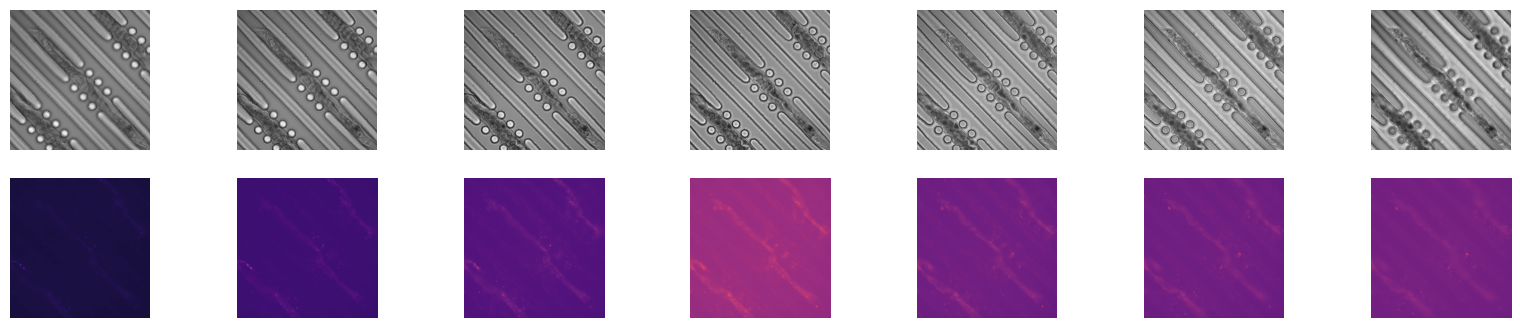

In [15]:
fig, axes = plt.subplots(2, 7, figsize=(20, 4))

for j in range(7):
    axes[0, j].imshow(wstack[0, j], cmap='gray')  # adjust the color map as per your image
    axes[0, j].axis('off')  # to remove the axes for individual images

    axes[1, j].imshow(wstack[2, j], cmap='magma')  # adjust the color map as per your image
    axes[1, j].axis('off')  # to remove the axes for individual images

plt.show()

In [22]:
r_stack_d = copy.deepcopy(wstack)
for i in range(9):
    r_stack_d[2,i] = model_import.predict(r_stack_d[2,i],'xy')

1/1 [==============================] - 0s 25ms/step


Creating a mask to display z-slices cleanly:

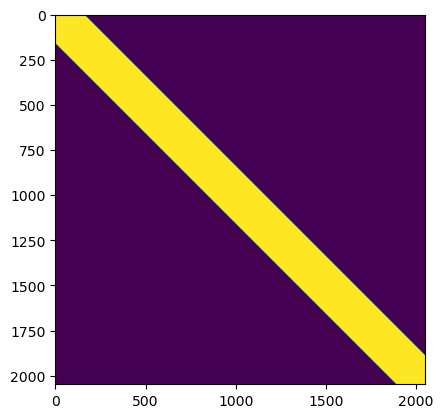

In [16]:
strip_width = 160
h = 2048
w = 2048

mask = np.zeros((h, w), dtype=np.uint16)

# Define the strip as a diagonal band in the mask
for i in range(w):
    mask[max(0, i-strip_width):min(h, i+strip_width), i] = 1
    
#plt.imshow(mask)

Displaying the denoised images along side the regular ones:

23.0
106.36937713623047


Text(0.5, 1.0, 'denoised red channel zstack')

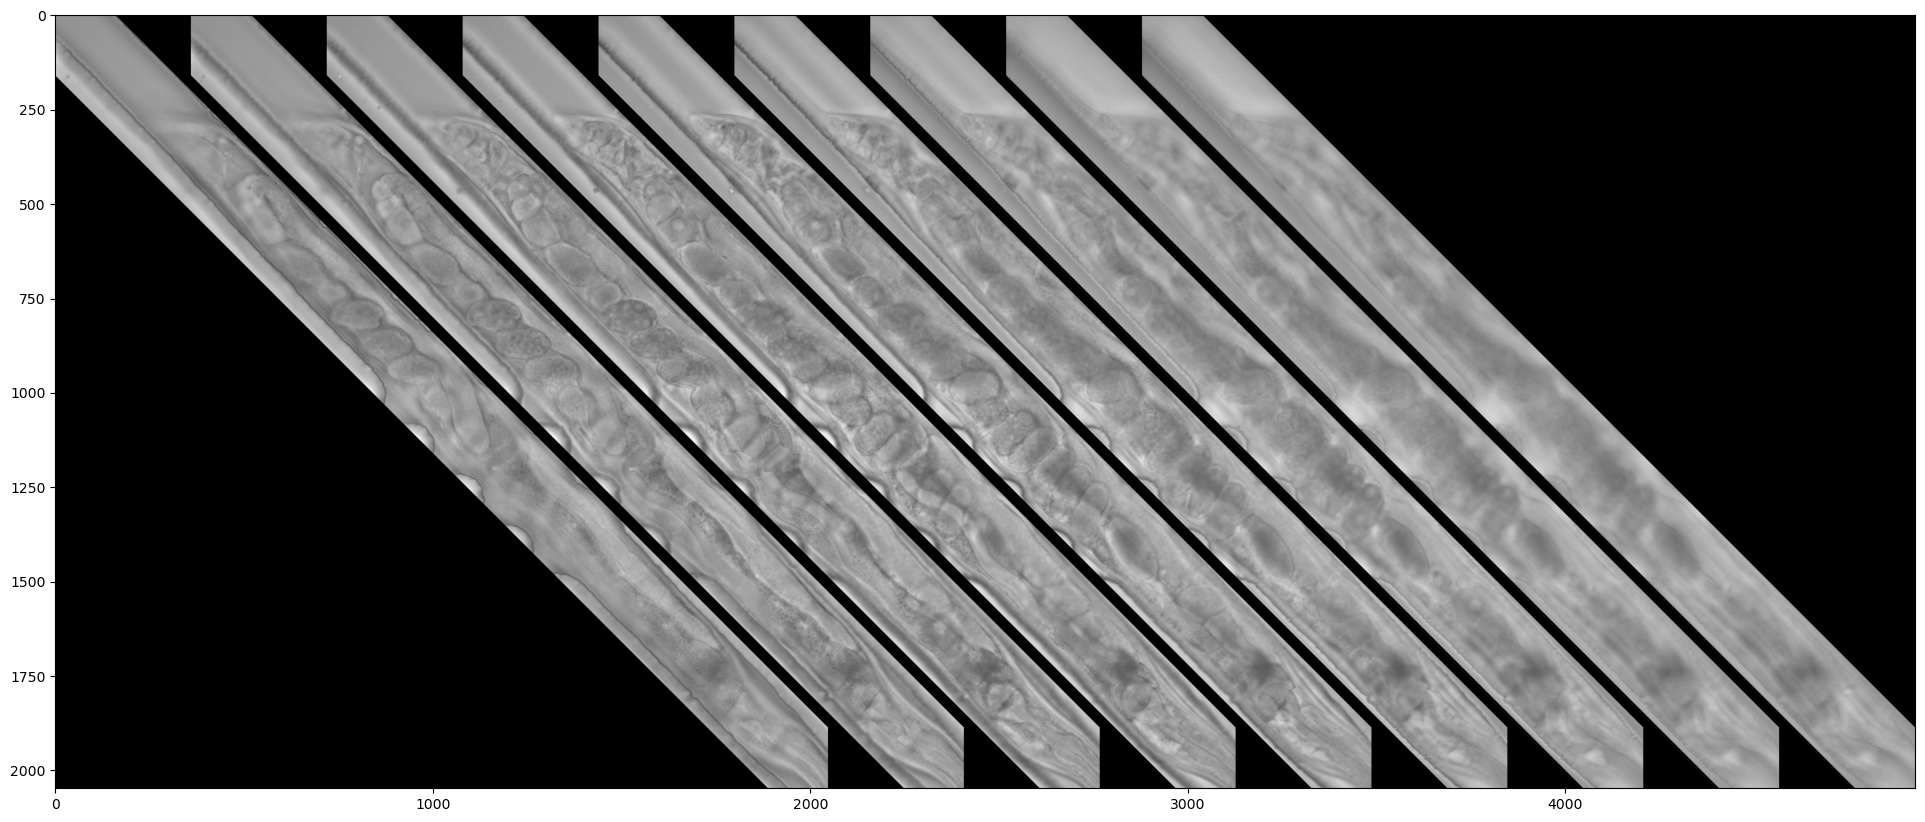

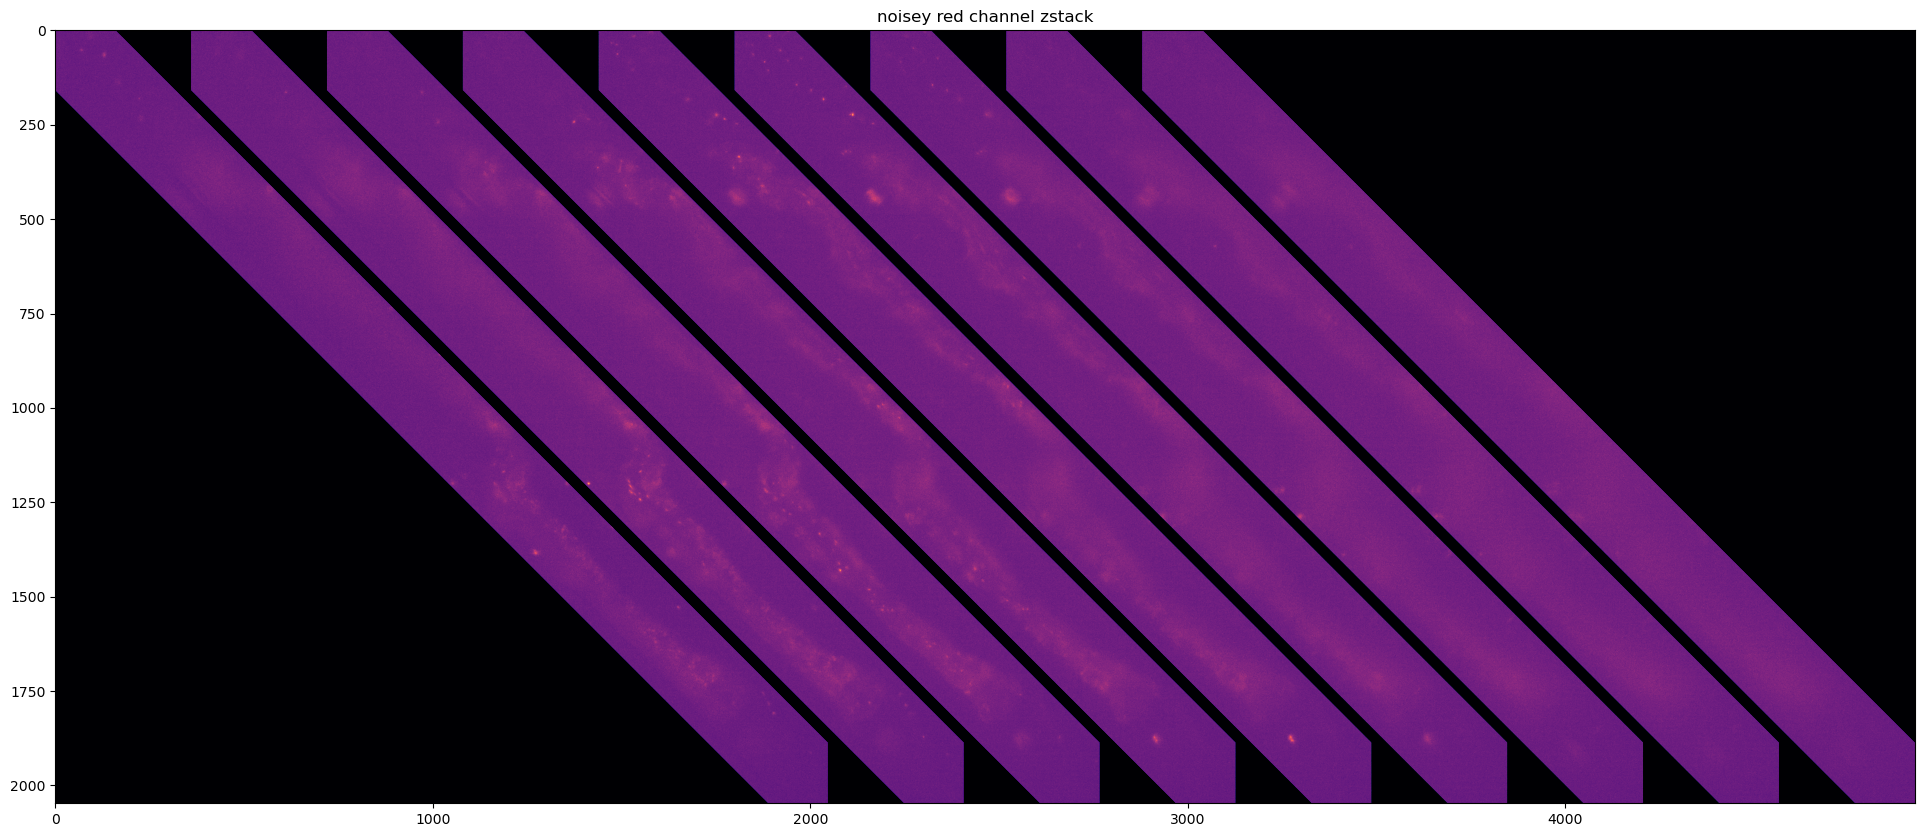

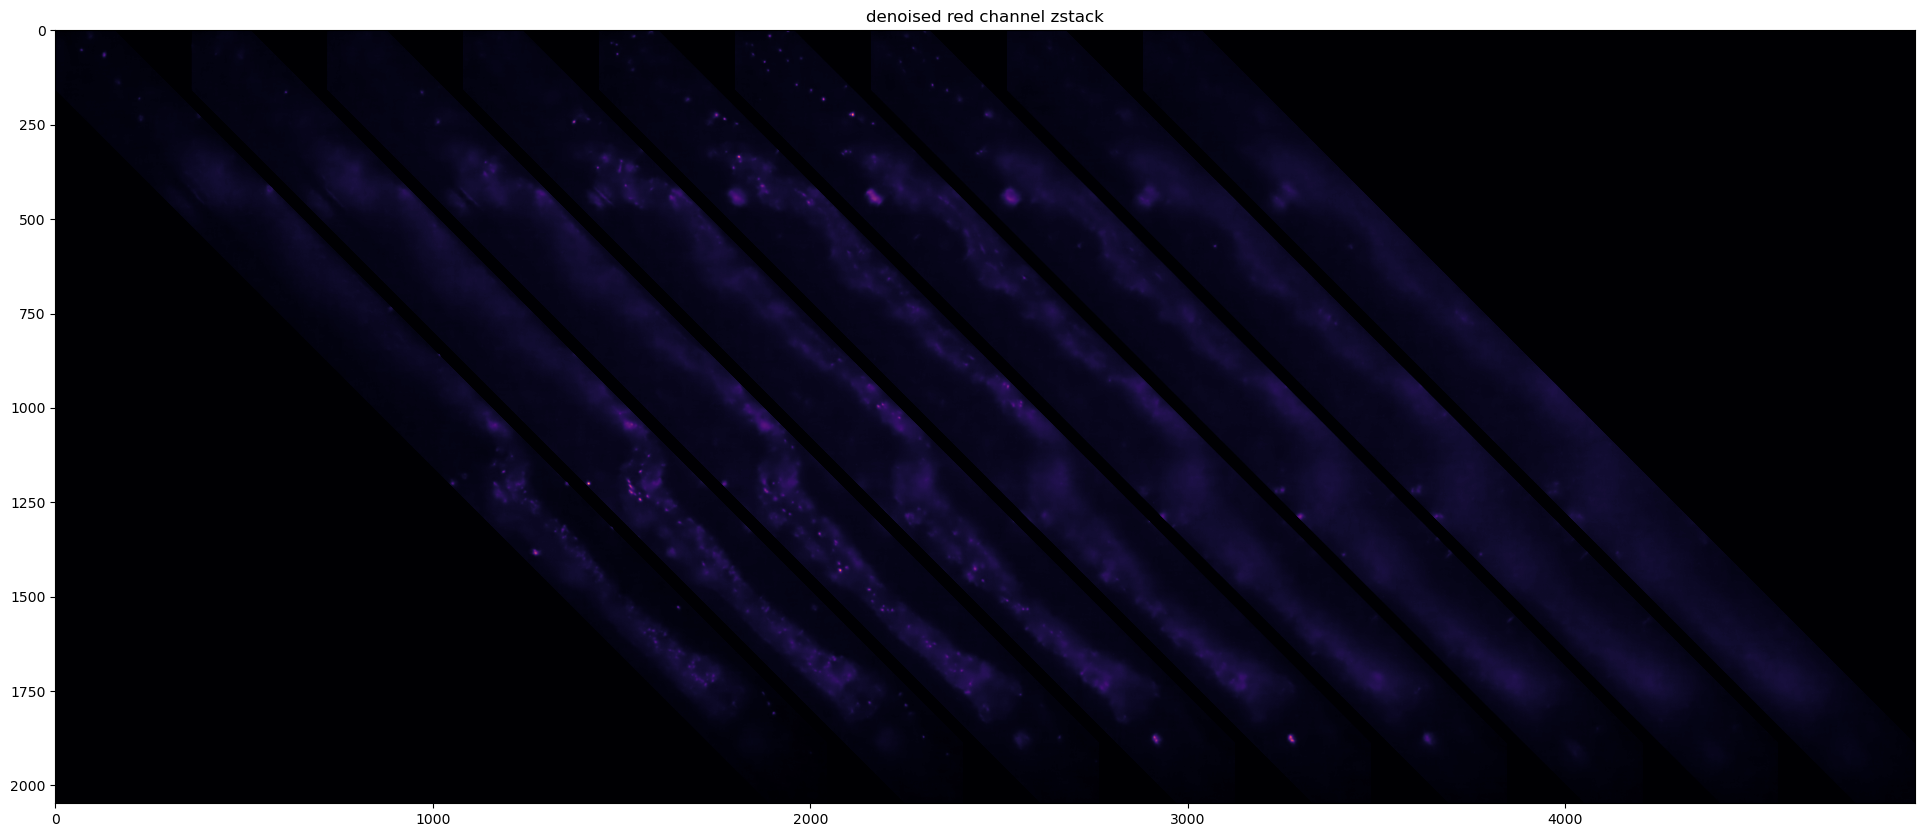

In [45]:
# create diagonal z_strip BF
st = af.create_diagonal_zwall(wstack,mask,chan = 0,delta = 360)
plt.figure(figsize = [24,36])

# plt BF
plt.imshow(st,'gray')#,vmin = min_value,vmax = np.max(st)**0.8)


# create diagonal z_strip red_chan
st = af.create_diagonal_zwall(wstack,mask,chan = 2,delta = 360)
plt.figure(figsize = [24,36])
flattened = st.flatten()
non_zero = flattened[flattened > 0]
min_value = np.min(non_zero)
print(min_value)
plt.imshow(st,'magma',vmin = min_value)#,vmax = np.max(st)**0.8)
plt.title('noisey red channel zstack');

# create diagonal z_strip  denoised red_chan
st = af.create_diagonal_zwall(r_stack_d,mask,chan = 2,delta = 360)
plt.figure(figsize = [24,36])
flattened = st.flatten()
non_zero = flattened[flattened > 0]
min_value = np.min(non_zero)
print(min_value)
plt.imshow(st,'magma',vmin = min_value)#,vmax = np.max(st)**0.8)
plt.title('denoised red channel zstack');

## Projecting the z-stack

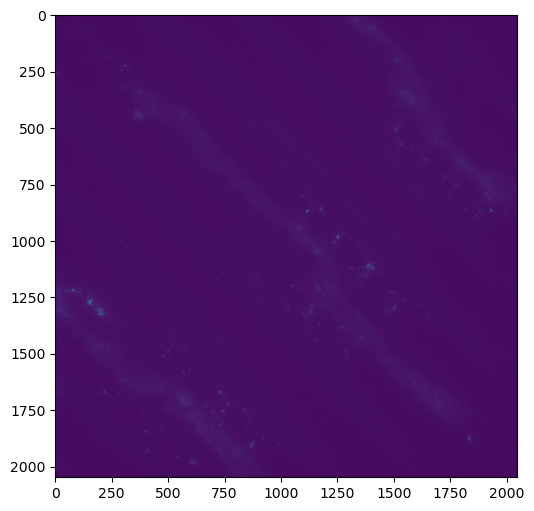

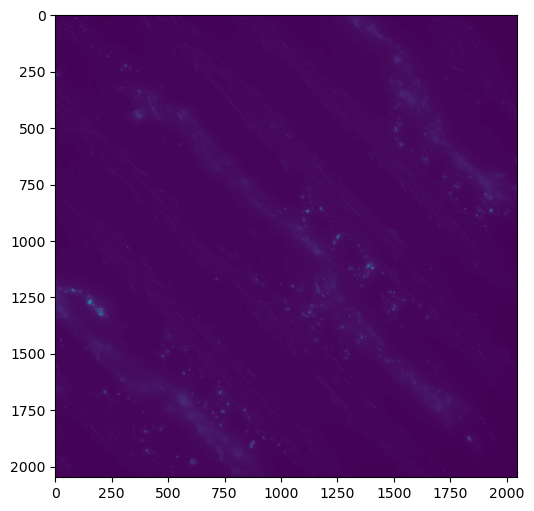

In [43]:
mxp = np.max(wstack[2,...],axis = 0)
plt.figure(figsize = [6,6])

plt.imshow(mxp)#,vmin = 100,vmax = np.max(mxp)**0.8)


mxp_d = np.max(r_stack_d[2,...],axis = 0)
plt.figure(figsize = [6,6])

plt.imshow(mxp_d)#,vmin = 100,vmax = np.max(mxp)**0.8)



Displaying original compressed z-stack and the denoised compressed z-stack side-by-side:

In [38]:
def create_diagonal_crop_wall_simple(wstack, mask, delta=500):
    # worm_n = stack.shape[0]

    rows = wstack.shape[1]
    cols = wstack.shape[2]
    numz = wstack.shape[0]
    length = 2048 + delta * (numz - 1)
    strip = np.zeros((2048, length))
    for i in range(numz):
        strip[:rows, i * delta:i * delta + cols] += wstack[ i, ...] * mask

    return strip

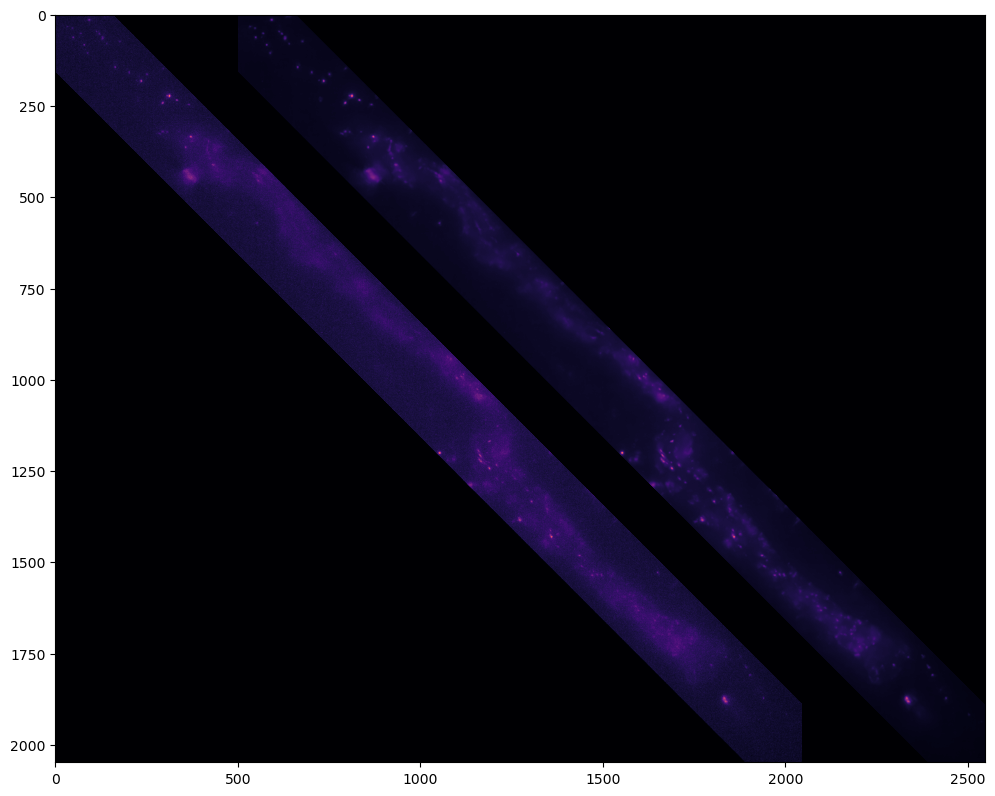

In [41]:
proj_wall = create_diagonal_crop_wall_simple(np.dstack((mxp,mxp_d)).transpose(2,0,1),mask)
flattened = proj_wall.flatten()
non_zero = flattened[flattened > 0]
min_value = np.min(non_zero)
plt.figure(figsize = [12,12])
plt.imshow(proj_wall,'magma',vmin = min_value)#,

## Future work
- Wrapper function
- Remove some of the demonstration cells